In [1]:
%matplotlib inline
# %matplotlib widget
%load_ext autoreload
%autoreload 2
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import sys
sys.path.insert(0, 'functions/')
from h5_tools import *
from fitting_tools import *

import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from Xana import Xana
from glob import glob
import re
from lmfit.models import LinearModel
from pathlib import Path
from tqdm import tqdm


import scipy as sp
import scipy.interpolate

#plt.style.use('../nbstyle.mplstyle')
mpl.rcParams.update({"axes.grid" : True, "grid.color": "gray", "grid.linestyle":":", "grid.alpha": "0.7"})

In [3]:
datadir = '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/'
anadir = '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed'
h5dir = '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/'

# Big function here

In [4]:
def get_scan_number(s):
    s = str(s)
    s = re.search('(?<=scan)\d{4}', s)
    if s is not None:
        return int(s.group(0))
    else:
        return -1
    
def get_rep(x, reps_per_spot=1):
    scan = get_scan_number(x)
    rep = scan % reps_per_spot
    if rep == 0:
        rep = 4
    return rep


def var(ttc):
        """Calculate the variance of the two-time correlation function.
        Args: ttc two-time correlation function (2d array)
        To normalize:
            chi4 = vartrc(ttc)
            chi4 /= np.average(ttc)**2
        """
        n, tmp = np.shape(ttc)
        ttc_var = []
        
        for off_diag in range(1, n-1):
            ttc_var.append(np.var(np.diag(ttc, off_diag)))
#         chi4 = ttc_var / np.average(ttc)**2

        return ttc_var

def var_norm(ttc):
        """Calculate the variance of the two-time correlation function.
        Args: ttc two-time correlation function (2d array)
        To normalize:
            chi4 = vartrc(ttc)
            chi4 /= np.average(ttc)**2
        """
        n, tmp = np.shape(ttc)
        ttc_var = []
        
        for i in range(1, n-1):
            ttc_var.append(np.var(np.diag(ttc, i)))
        chi4 = ttc_var / np.average(np.diag(ttc, k=0))**2

        return chi4

def load_ttc(filename, qpar=2, rep=0, vs=(0,0.15), ttc_key='/xpcs/ttcs/ttc_rep_qs_avg_filtered'):
    """ Load average twotime correlation function for different a given momentum transfer """
    ttc_qv = load_data(filename, '/xpcs/ttcs/q')
    # ttc_pars = load_data(filename, '/xpcs/ttcs/twotime_par')
    time = load_data(filename, '/xpcs/ttcs/times')

    qv = d.get_item(ind_xpcs[0])['qv'][qpar]

    with h5py.File(filename, 'r') as f:
        ttc = np.asarray(f[ttc_key][qpar])[rep,:,:]
    
    return ttc, qv


def log_interp1d(xx, yy, kind='linear'):

    result = np.where(yy > 0.0000000001, yy, -10)
    logy = np.log10(result, out=result, where=result > 0)


    logx = np.log10(xx)
    # logy = np.log10(yy)
    lin_interp = sp.interpolate.interp1d(logx, logy, kind=kind)
    log_interp = lambda zz: np.power(10.0, lin_interp(np.log10(zz)))

    return log_interp

In [5]:
def chi4_do_everything(runnames, datasetnumbers, T, c, q_index=2, save=True):

    for j, (runname,datasetnumber) in enumerate(zip(runnames,datasetnumbers)):
        # h5_filename = f'{runname}_{datasetnumber:04d}'
        print('\n',runname,datasetnumber, f'{runname}_{datasetnumber:04d}')

        # get database files
        ana_db_files = glob(f'{anadir}/results/{runname}_{datasetnumber:04d}/p*/analysis_database.pkl')
        # ana_db_files = glob(f'{anadir}/results/{datafolder}_{datasetnumber:04d}/p34*/analysis_database.pkl') # for c2
        print('\tdabase files:\n\t', ana_db_files)

        # load database
        d = Xana(fmtstr='ebs_id10_eiger500k', detector='eiger500k', setupfile=f'{anadir}/mask-setup/setup-fullmask-cryo-230417.pkl')
        maskfile = d.setup.maskfile
        d = Xana(fmtstr='ebs_id10_eiger500k', detector='eiger500k', setupfile=f'{anadir}/mask-setup/setup-fullmask-cryo-230417.pkl', maskfile=maskfile)

        for i, f in enumerate(ana_db_files):
            if i == 0:
                d.load_db(f)
            else:
                d.append_db(f)

        # add repetition entry in the database
        d.db['rep'] = d.db['master'].apply(lambda x: get_rep(x, reps_per_spot=4))
        d.db['scannumber'] = d.db['datdir'].apply(lambda x: get_scan_number(str(x)))

        # select xpcs indeces
        rep = 1
        ind_xpcs = d.db[(d.db['analysis'] == 'xpcs') & (d.db['rep'] == rep)].index.values
        print(f"number of xpcs analysis: {len(ind_xpcs)}")
        #d.db.loc[ind_xpcs]

        # compute chi4
        # chi4s1 = []
        chi4s2 = []
        time = d.get_item(ind_xpcs[0])['twotime_xy'][1:-1]
        qv = d.get_item(ind_xpcs[0])['qv']
        qpar = d.get_item(ind_xpcs[0])['twotime_par']
        print("qv: ", qv, qpar, qv[qpar])

        for i,ind in tqdm(enumerate(ind_xpcs[:]), desc='index', leave=False, total=len(ind_xpcs)):
            chi4s2.append(var_norm(list(d.get_item(ind)['twotime_corf'].values())[q_index]))
            # chi4s1.append(var(list(d.get_item(ind)['twotime_corf'].values())[2]))


        # # load avg ttc - can be added later
        # filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'
        # if os.path.isfile(filename):
        #     print('\th5 filename:', filename)
        #     ttc, qv_ttc = load_ttc(filename)#, qpar=2, rep=0, vs=(0,0.15), ttc_key='/xpcs/ttcs/ttc_rep_qs_avg_filtered')
        # else:
        #     print(f'file {fielname} does not exist') 

        # # chi4 from average ttc
        # chi4_ttc = var_norm(ttc)

        # mean chi4 from the single chi4 from each ttc
        chi4_2, dchi4_2 = np.mean(chi4s2, axis=0), np.std(chi4s2, axis=0) / np.sqrt(len(chi4s2))


        # -- plot chi4 from single ttcs
        # -- plot interpolated chi4 
        fig, (a2,a1) = plt.subplots(1,2, figsize=(8.5,4), tight_layout=True)
        cs = plt.cm.viridis(np.linspace(0,1,len(chi4s2)))
        cols2 = plt.cm.viridis(np.linspace(0,1,len(chi4s2)))

        # show all chi4 and avg
        for i in range(0,len(chi4s2),5):
            a2.plot(time, chi4s2[i], lw=1, c=cols2[i], alpha=.5)

        a2.errorbar(time, chi4_2, dchi4_2, c='k', ls='-', label='avg') # marker='o', mfc='none',

        # log interpolation
        new_x = np.logspace(np.log10(time[0]), np.log10(time[-1]), 20)
        f = log_interp1d(time[:], chi4_2[:])
        df = log_interp1d(time[:], dchi4_2[:])

        base = np.mean(f(new_x)[-8:-1])
        a1.plot(time, chi4_2, c='gray', ls='-', alpha=0.7,lw=0.7, label='avg')
        a1.errorbar(new_x[:-1], f(new_x)[:-1], df(new_x)[:-1],c='r', marker='o', mfc='none', ls='', label='interp')
        # fit
        popt,xc,curve,perr = fit(exponential, new_x[:-1], f(new_x)[:-1], sigma= df(new_x)[:-1], p0=[2.5,5e-3], bounds=[(0,0),(np.infty,np.infty)])
        a1.plot(xc, curve, ls='-', c='k', label=f'fit: t={popt[1]:.2e} ± {perr[1]:.2e} s')
        # from ttc avg
        # f2 = log_interp1d(time[:], chi4_ttc[:])
        # base = np.mean(f2(new_x)[-8:-1])
        # a1.plot(new_x[:-1], f2(new_x)[:-1], c='b', ls='', alpha=0.7, marker='s', mfc='none', label='from ttc')
        # a1.plot(time[:-100], chi4_ttc[:-100], c='b', ls='', alpha=0.7, marker='s', mfc='none', label='from ttc')
        # a1.plot(new_x, np.zeros(len(new_x)), c='r', marker='x', mfc='none', ls='-', label='interp')
        a1.set_xscale('log')
        a1.legend()
        a1.grid(ls=':', c='gray', alpha=0.7)
        a1.set_xlabel('tau (s)')
        a1.set_ylabel('Chi_4')
        # a1.set_ylim(20,30)
        a1.set_xlim(0,1)
        a1.set_title(f'{runname} {datasetnumber}, q_ind={q_index}')
        a2.set_xscale('log')
        a2.legend()
        a2.grid(ls=':', c='gray', alpha=0.7)
        a2.set_xlabel('tau (s)')
        a2.set_ylabel('Chi_4')
        # a2.set_ylim(10,50)
        a2.set_xlim(0,1)
        a2.set_title(f'{runname} {datasetnumber}')

        if save:
            npz_name = f'../03-source/chi4_{c}_{T[j]}K_qind{q_index}'
            print("\n\t", f"saving npz file as {npz_name}")
            np.savez(npz_name, time=new_x[:-1], chi4=f(new_x)[:-1], dchi4=df(new_x)[:-1])


## Set paramenters

In [6]:
# c1
# c = 'c1'
# runnames = ['ferritin_conc_gly_50_6', 'ferritin_conc_gly_50_6', 'ferritin_conc_gly_50_6', 'ferritin_conc_gly_50_6', 'ferritin_conc_gly_50_6']
# datasetnumbers = [2,3,4,5,6]
# T = [250,240,230,220,210]

# # c2
# c = 'c2'
# runnames = ['ferritin_conc100_gly_50_1', 'ferritin_conc100_gly_50_1', 'ferritin_conc100_gly_50_1']
# datasetnumbers = [12,6,9]
# T = [260,250,240]

# # # c3 temps 260-230 K full beam
c = 'c3'
runnames = ['ferritin_conc120_gly_50_1', 'ferritin_conc120_gly_50_1', 'ferritin_conc120_gly_50_1', 'ferritin_conc120_gly_50_1']
datasetnumbers = [4,5,7,8]
T = [260,250,240,230]



 ferritin_conc120_gly_50_1 4 ferritin_conc120_gly_50_1_0004
	dabase files:
	 ['/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/results/ferritin_conc120_gly_50_1_0004/p341550/analysis_database.pkl', '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/results/ferritin_conc120_gly_50_1_0004/p341570/analysis_database.pkl', '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/results/ferritin_conc120_gly_50_1_0004/p341569/analysis_database.pkl', '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/results/ferritin_conc120_gly_50_1_0004/p341564/analysis_database.pkl']
Loaded setupfile:
	/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/mask-setup/setup-fullmask-cryo-230417.pkl.
Loaded setupfile:
	/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/mask-setup/setup-fullmask-cryo-230417.pkl.
Try loading database:
	/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/results/ferritin_conc120_gly_50_1_0004/p341550/analysis_database.pkl
Succ

/tmp/ipykernel_39817/4088609980.py:96: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  a1.set_xlim(0,1)
/tmp/ipykernel_39817/4088609980.py:104: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  a2.set_xlim(0,1)



	 saving npz file as ../03-source/chi4_c3_260K_qind4

 ferritin_conc120_gly_50_1 5 ferritin_conc120_gly_50_1_0005
	dabase files:
	 ['/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/results/ferritin_conc120_gly_50_1_0005/p341551/analysis_database.pkl', '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/results/ferritin_conc120_gly_50_1_0005/p341609/analysis_database.pkl', '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/results/ferritin_conc120_gly_50_1_0005/p341598/analysis_database.pkl', '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/results/ferritin_conc120_gly_50_1_0005/p341602/analysis_database.pkl']
Loaded setupfile:
	/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/mask-setup/setup-fullmask-cryo-230417.pkl.
Loaded setupfile:
	/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/mask-setup/setup-fullmask-cryo-230417.pkl.
Try loading database:
	/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/results/ferritin_co

/tmp/ipykernel_39817/4088609980.py:96: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  a1.set_xlim(0,1)
/tmp/ipykernel_39817/4088609980.py:104: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  a2.set_xlim(0,1)



	 saving npz file as ../03-source/chi4_c3_250K_qind4

 ferritin_conc120_gly_50_1 7 ferritin_conc120_gly_50_1_0007
	dabase files:
	 ['/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/results/ferritin_conc120_gly_50_1_0007/p341552/analysis_database.pkl', '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/results/ferritin_conc120_gly_50_1_0007/p341615/analysis_database.pkl', '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/results/ferritin_conc120_gly_50_1_0007/p341611/analysis_database.pkl', '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/results/ferritin_conc120_gly_50_1_0007/p341616/analysis_database.pkl']
Loaded setupfile:
	/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/mask-setup/setup-fullmask-cryo-230417.pkl.
Loaded setupfile:
	/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/mask-setup/setup-fullmask-cryo-230417.pkl.
Try loading database:
	/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/results/ferritin_co

/tmp/ipykernel_39817/4088609980.py:96: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  a1.set_xlim(0,1)
/tmp/ipykernel_39817/4088609980.py:104: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  a2.set_xlim(0,1)



	 saving npz file as ../03-source/chi4_c3_240K_qind4

 ferritin_conc120_gly_50_1 8 ferritin_conc120_gly_50_1_0008
	dabase files:
	 ['/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/results/ferritin_conc120_gly_50_1_0008/p341628/analysis_database.pkl', '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/results/ferritin_conc120_gly_50_1_0008/p341553/analysis_database.pkl', '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/results/ferritin_conc120_gly_50_1_0008/p341630/analysis_database.pkl', '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/results/ferritin_conc120_gly_50_1_0008/p341629/analysis_database.pkl']
Loaded setupfile:
	/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/mask-setup/setup-fullmask-cryo-230417.pkl.
Loaded setupfile:
	/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/mask-setup/setup-fullmask-cryo-230417.pkl.
Try loading database:
	/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/results/ferritin_co

/tmp/ipykernel_39817/4088609980.py:96: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  a1.set_xlim(0,1)
/tmp/ipykernel_39817/4088609980.py:104: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  a2.set_xlim(0,1)



	 saving npz file as ../03-source/chi4_c3_230K_qind4


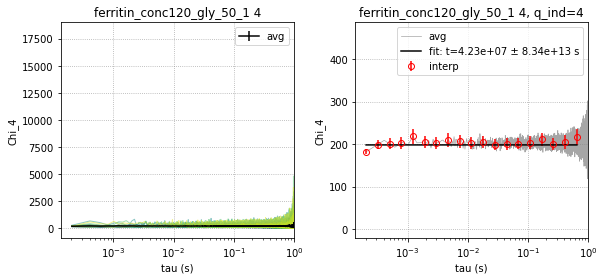

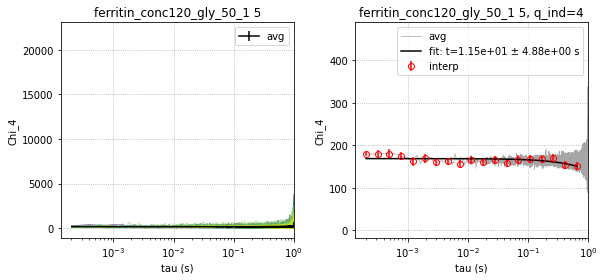

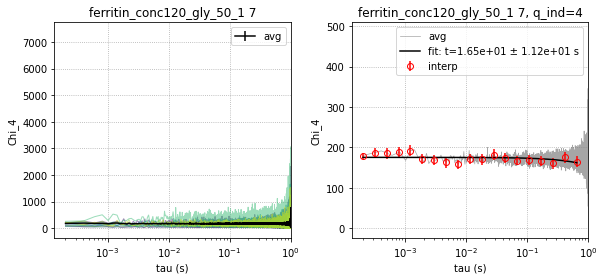

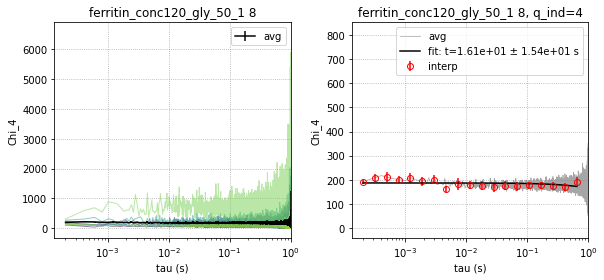

In [7]:
if len(runnames) == len(datasetnumbers):
    chi4_do_everything(runnames, datasetnumbers, T, c, q_index=4, save=True)

# plots to compare things

## conentrations at the same temperature

In [12]:
cs = ['c1', 'c2', 'c3']
times_240, chis_240, dchis_240 = [], [], []

for c in cs:
    f = np.load(f'../03-source/chi4_{c}_240K.npz')
    chis_240.append(f['chi4'])
    dchis_240.append(f['dchi4'])
    times_240.append(f['time'])

/tmp/ipykernel_48223/3840568656.py:23: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  a1.set_xlim(0,1)


Text(0.5, 0, 'concentrations')

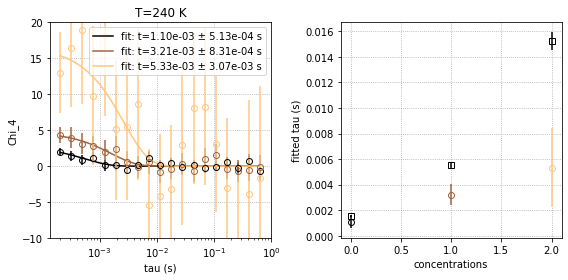

In [13]:
f, (a1,a2) = plt.subplots(1,2, figsize=(8,4), tight_layout=True)
col = plt.cm.copper(np.linspace(0,1,len(cs)))

taus_g2 = [1.54e-3, 5.5e-3, 15.23e-3]
dtaus_g2 = [0.07e-3, 0.2e-3, 0.7e-3]

for i in range(len(cs)):
    b = np.mean(chis_240[i][-7:])
    a1.errorbar(times_240[i], chis_240[i]-b, dchis_240[i],  marker='o', mfc='none', ls='', c=col[i])
    
    popt,xc,curve,perr = fit(exponential, times_240[i], chis_240[i]-b, sigma=dchis_240[i], p0=[2.5,5e-3], bounds=[(0,0),(np.infty,np.infty)])
    a1.plot(xc, curve, ls='-', c=col[i], label=f'fit: t={popt[1]:.2e} ± {perr[1]:.2e} s')

    a2.errorbar(i, popt[1], perr[1], ls='', marker='o', c=col[i], mfc='none')
    a2.errorbar(i, taus_g2[i], dtaus_g2[i], ls='', c='k', marker='s', mfc='none')

a1.grid(ls=':', c='gray', alpha=0.7)
a1.set_xlabel('tau (s)')
a1.set_ylabel('Chi_4')
a1.set_xscale('log')
a1.legend()
a1.set_ylim(-10,20)
a1.set_xlim(0,1)
a1.set_title('T=240 K')

a2.set_ylabel('fitted tau (s)')
a2.set_xlabel('concentrations')

## temperatures

In [14]:
# conc = 'c1'
# temps = [250,240,230,220,210]

# conc = 'c2'
# temps = [260,250,240]

conc = 'c3'
temps = [260,250,240,230]

In [19]:
import glob
npzfiles = sorted(glob.glob(f"../03-source/chi4_{conc}*qind3.npz"))[::-1]
npzfiles

['../03-source/chi4_c3_260K_qind3.npz',
 '../03-source/chi4_c3_250K_qind3.npz',
 '../03-source/chi4_c3_240K_qind3.npz',
 '../03-source/chi4_c3_230K_qind3.npz']

In [20]:
chis_c, dchis_c, times_c = [], [], []

for i in range(len(npzfiles)):
    f = np.load(npzfiles[i])
    chis_c.append(f['chi4'])
    dchis_c.append(f['dchi4'])
    times_c.append(f['time'])

print(np.shape(chis_c), np.shape(dchis_c), np.shape(times_c))

(4, 19) (4, 19) (4, 19)


/tmp/ipykernel_48223/2273223916.py:18: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  a1.set_xlim(0,1)


Text(0.5, 1.0, 'c3')

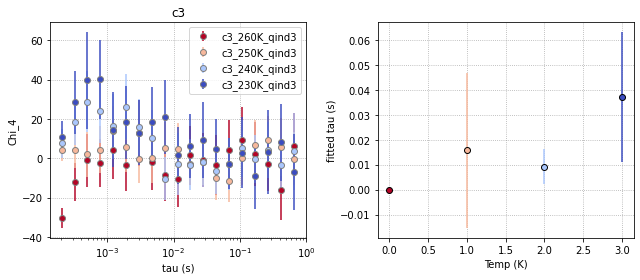

In [21]:
f, (a1,a2) = plt.subplots(1,2, figsize=(9,4), tight_layout=True)
col = plt.cm.coolwarm_r(np.linspace(0,1,len(npzfiles)))

for i in range(len(npzfiles)):
    b = np.mean(chis_c[i][-7:])
    a1.errorbar(times_c[i], chis_c[i]-b, dchis_c[i],  marker='o', mec='gray', ls='', c=col[i], label=f'{npzfiles[i][18:-4]}')
    
    popt,xc,curve,perr = fit(exponential, times_c[i], chis_c[i]-b, sigma=dchis_c[i], p0=[2,8e-3], bounds=[(0,0),(np.infty,np.infty)])
    # a1.plot(xc, curve, c='k', lw=1)
    a2.errorbar(i, popt[1], perr[1], ls='', marker='o', c=col[i], mec='k')

a1.grid(ls=':', c='gray', alpha=0.7)
a1.set_xlabel('tau (s)')
a1.set_ylabel('Chi_4')
a1.set_xscale('log')
a1.legend()
# a1.set_ylim(-3,5)
a1.set_xlim(0,1)
a2.set_ylabel('fitted tau (s)')
a2.set_xlabel('Temp (K)')
a1.set_title(f'{conc}')

In [22]:
# files = ['../03-source/chi4_c2_240K.npz','../03-source/chi4_c2_240K_qind3.npz', '../03-source/chi4_c2_240K_qind4.npz','../03-source/chi4_c2_240K_qind5.npz','../03-source/chi4_c2_240K_qind6.npz', '../03-source/chi4_c2_240K_qind7.npz', '../03-source/chi4_c2_240K_qind8.npz', '../03-source/chi4_c2_240K_qind9.npz']
files = ['../03-source/chi4_c3_230K.npz', '../03-source/chi4_c3_230K_qind3.npz']

chis_c, dchis_c, times_c = [], [], []

for i in range(len(files)):
    f = np.load(files[i])
    chis_c.append(f['chi4'])
    dchis_c.append(f['dchi4'])
    times_c.append(f['time'])

print(np.shape(chis_c), np.shape(dchis_c), np.shape(times_c))

(2, 19) (2, 19) (2, 19)


/tmp/ipykernel_48223/1791051975.py:18: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  a1.set_xlim(0,1)


Text(0.5, 1.0, 'c3')

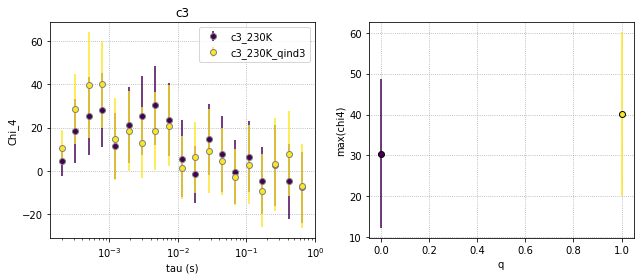

In [23]:
f, (a1,a2) = plt.subplots(1,2, figsize=(9,4), tight_layout=True)
col = plt.cm.viridis(np.linspace(0,1,len(files)))

for i in range(len(files)):
    b = np.mean(chis_c[i][-7:])
    a1.errorbar(times_c[i], chis_c[i]-b, dchis_c[i],  marker='o', mec='gray', ls='', c=col[i], label=f'{files[i][18:-4]}')
    
    # popt,xc,curve,perr = fit(exponential, times_c[i], chis_c[i]-b, sigma=dchis_c[i], p0=[2,8e-3], bounds=[(0,0),(np.infty,np.infty)])
    # a1.plot(xc, curve, c='k', lw=1)
    a2.errorbar(i, np.max(chis_c[i]-b), dchis_c[i][np.argmax(chis_c[i]-b)], ls='', marker='o', c=col[i], mec='k')

a1.grid(ls=':', c='gray', alpha=0.7)
a1.set_xlabel('tau (s)')
a1.set_ylabel('Chi_4')
a1.set_xscale('log')
a1.legend()
# a1.set_ylim(-3,5)
a1.set_xlim(0,1)
a2.set_ylabel('max(chi4)')
a2.set_xlabel('q')
a1.set_title(f'{conc}')

# TTC

In [23]:
qpar = 2
qv = d.get_item(ind_xpcs[0])['qv'][qpar]
ttc_1 = d.get_item(ind_xpcs[0])['twotime_corf'][qpar]

In [24]:
filename = h5dir + f'{datafolder}_{datasetnumber:04d}.h5'
ttc, qv_ttc = load_ttc(filename)#, qpar=2, rep=0, vs=(0,0.15), ttc_key='/xpcs/ttcs/ttc_rep_qs_avg_filtered')

/tmp/ipykernel_32576/508662769.py:7: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(shrink=.8)


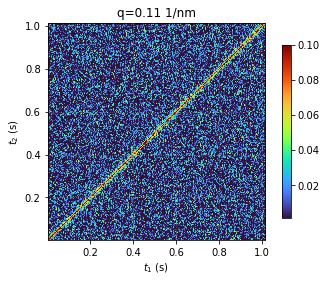

In [30]:
plt.figure()
norm = np.mean(ttc[:300,-300:])
plt.imshow(ttc-norm, cmap='turbo', extent=(time[0], time[-1])*2, origin='lower', vmax=1e-1, vmin=1e-3)
plt.xlabel('$t_1$ (s)')
plt.ylabel('$t_2$ (s)')
plt.title(f'q={qv:.2f} 1/nm')
plt.colorbar(shrink=.8)

/tmp/ipykernel_32576/1704467438.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(shrink=.8)


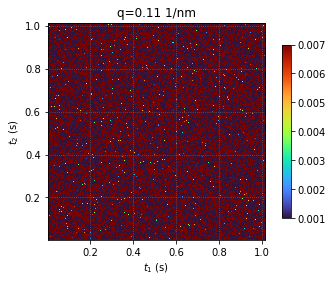

In [29]:
plt.figure()
norm = np.mean(ttc_1[:300,-300:])
plt.imshow(ttc_1-norm, cmap='turbo', extent=(time[0], time[-1])*2, origin='lower', vmax=7e-3, vmin=1e-3)

plt.xlabel('$t_1$ (s)')
plt.ylabel('$t_2$ (s)')
plt.title(f'q={qv:.2f} 1/nm')
plt.colorbar(shrink=.8)

In [ ]:

    
# for i in range(0,len(ttc_qv)):
#     ax = axs.ravel()[i]
#     norm = np.mean(ttcs[i,:300,-300:])


def plot_ttc(filename, rep=0, vs=(0,0.15), ttc_key='/xpcs/ttcs/ttc_rep_qs_avg_filtered'):
    """Plots the twotime correlation function for different momentum transfers"""
    ttc_qv = load_data(filename, '/xpcs/ttcs/q')
    # ttc_pars = load_data(filename, '/xpcs/ttcs/twotime_par')
    time = load_data(filename, '/xpcs/ttcs/times')
    
    ttcs = np.empty(shape=(len(ttc_qv), len(time), len(time)))
    with h5py.File(filename, 'r') as f:
        ttcs = np.asarray(f[ttc_key])[rep,:,:,:]
        
    # f, axs = plt.subplots(2,3,figsize=(10,6), tight_layout=True)
    f, axs = plt.subplots(2,5,figsize=(15,6), tight_layout=True)
    for i in range(0,len(ttc_qv)):
        ax = axs.ravel()[i]
        norm = np.mean(ttcs[i,:300,-300:])
        # vmax = np.mean(np.diag(ttcs[i,:,:],k=10))

        ax.imshow(ttcs[i,:,:]-norm, origin='lower', cmap='turbo', vmin=vs[0], vmax=vs[1], extent=(time[0],time[-1])*2 )
        ax.set_xlabel('$t_1 (s)$')
        ax.set_title(f'{ttc_qv[i]:.2f} 1/nm', fontsize=8)
        ax.set_ylabel('$t_2 (s)$')
        divider = make_axes_locatable(ax)
        cb1 = mpl.colorbar.ColorbarBase(divider.append_axes('right', size='5%', pad=0.05), cmap=mpl.cm.turbo,  orientation='vertical', norm=mpl.colors.Normalize(vmin=vs[0],vmax=vs[1]));


# Functions

In [ ]:
def vartrc(ttc):
        """Calculate the variance of the two-time correlation function.
        Args: ttc tto-time correlation function (2d array)
        To normalize:
            chi4 = vartrc(ttc)
            chi4 /= np.average(ttc)**2
        """
        n, tmp = np.shape(ttc)
        ttc_var = []
        
        for i in range(1, n-1):
            ttc_var.append(np.var(np.diag(ttc, i)))
#         chi4 = ttc_var / np.average(ttc)**2

        return ttc_var